## A/B Testing website conversion

A/B testing on a website to test whether the experimental yields a better conversion rate for a website than the current theme


The motivation is to understand and control the variables within the A/B test.

Note: this is a very simple experiment which does not factor in the funnel and journey to conversion or track bounce rate etc.

Notebook copied from: [Notebook](https://www.kaggle.com/code/richieone13/a-b-testing-example) and developed by [Richieone13](https://www.kaggle.com/richieone13)

 

## 1. Designing the experiement

Formulating an experiment

Given we don’t know if the new design will perform better or worse (or the same?) as our current design, we’ll choose a two-tailed test:

Hₒ: p = pₒ

Hₐ: p ≠ pₒ

where p and pₒ stand for the conversion rate of the new and old design, respectively. We’ll also set a confidence level of 95%:


### Choosing the variables

For our test we’ll need two groups:

A control group - They'll be shown the old design

A treatment (or experimental) group - They'll be shown the new design


This will be our Independent Variable. 

The reason we have two groups even though we know the baseline conversion rate is that we want to control for other variables that could have an effect on our results: by having a control group we can directly compare their results to the treatment group, because the only systematic difference between the groups is the design of the landing page, and we can therefore attribute any differences in results to the designs.

For our Dependent Variable (i.e. what we are trying to measure), we are interested in capturing the conversion rate. A way we can code this is by each user session with a binary variable:

0 - The user did not buy the product during this user session

1 - The user bought the product during this user session

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.

### Choosing a sample size
It is important to note that since we won’t test the whole user base (our population), the conversion rates that we’ll get will inevitably be only estimates of the true rates.

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.

On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.
So how many people should we have in each group?

In [1]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

4720


We’d need at least the number of observations for each group and have a 90% chance to test it is significantly significant

## 2. Collecting and preparing the data

In [2]:
# importing the datas sample
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ab-testing/ab_data.csv


In [3]:
# sample of what the collated data looks like
df = pd.read_csv('/kaggle/input/ab-testing/ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
df.info

<bound method DataFrame.info of         user_id                   timestamp      group landing_page  converted
0        851104  2017-01-21 22:11:48.556739    control     old_page          0
1        804228  2017-01-12 08:01:45.159739    control     old_page          0
2        661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3        853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4        864975  2017-01-21 01:52:26.210827    control     old_page          1
...         ...                         ...        ...          ...        ...
294473   751197  2017-01-03 22:28:38.630509    control     old_page          0
294474   945152  2017-01-12 00:51:57.078372    control     old_page          0
294475   734608  2017-01-22 11:45:03.439544    control     old_page          0
294476   697314  2017-01-15 01:20:28.957438    control     old_page          0
294477   715931  2017-01-16 12:40:24.467417  treatment     new_page          0

[294478 rows x 5 co

In [5]:
# the dataset contains users that have experienced both the new and old pages.
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [6]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [7]:
# we drop the second time the instance used the homepage
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [8]:
# the dataset is now cleaner as can see the user experience only one page
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


### Sampling

We only sample the required amount the show from the power test.

We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [9]:
# here we collated the required n from each group as defined earlier

control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22) 
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [10]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [11]:
ab_test['group'].value_counts()

treatment    4720
control      4720
Name: group, dtype: int64

## 3. Visualising the results

The first thing we can do is to calculate some basic statistics to get an idea of what our samples look like.

In [12]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


Judging by the stats above, it does look like our two designs performed very similarly, with our new design performing slightly better average conversion rate.

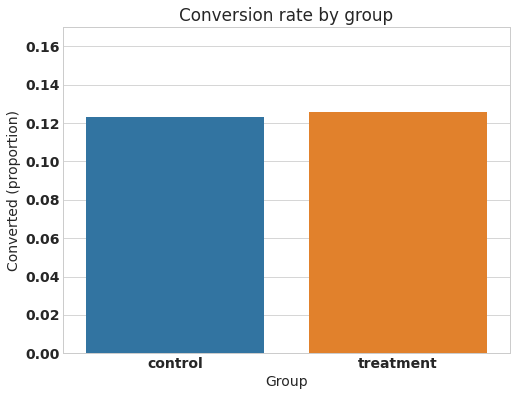

In [13]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group')
plt.xlabel('Group')
plt.ylabel('Converted (proportion)');

## 4. Testing the hypothesis

In [14]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


## 5. Drawing Conclusion

Since our p-value is above our α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that our new design did not perform significantly different (let alone better) than our old one.

Additionally, if we look at the confidence interval for the treatment group we notice that:

It includes our baseline value of 13% conversion rate. It does not include our target value of 15% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we go back to redesign.

Guide from Renato of sample to 
https://medium.com/@RenatoFillinich/ab-testing-with-python-e5964dd66143
